In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [218]:
from scipy.stats import ttest_rel
from sklearn.preprocessing import StandardScaler

In [242]:
data_raw = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181')
data_raw.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [244]:
data = data_raw.drop(columns=['is_cutoff', 'cutoff_factor','cutoff_timestamp', 'factor', 'segment_factor'])

In [245]:
col = ['trip_creation_time', 'od_start_time', 'od_end_time']
data[col] = data[col].apply(pd.to_datetime)

In [246]:
data = pd.get_dummies(data, columns=['route_type'], prefix='route', dtype=int)

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   trip_uuid                       144867 non-null  object        
 4   source_center                   144867 non-null  object        
 5   source_name                     144574 non-null  object        
 6   destination_center              144867 non-null  object        
 7   destination_name                144606 non-null  object        
 8   od_start_time                   144867 non-null  datetime64[ns]
 9   od_end_time                     144867 non-null  datetime64[ns]
 10  start_scan_to_end_scan          144867 non-null  float64

In [248]:
data.isna().sum()

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0
od_end_time,0


In [249]:
data.dropna(subset='source_name', inplace=True)
data.dropna(subset='destination_name', inplace=True)

In [250]:
data.groupby('source_center')['source_name'].nunique().reset_index().query('source_name > 1')

,source_center,source_name


Each source name have unique source center, therefore, we cannot fill null source name with mode as it will create messy data.

In [251]:
data['source_name'] = data['source_name'].str[:-1]
data[['source_code', 'source_state']] = data['source_name'].str.split(' \\(', expand=True).iloc[:,:2]
parts = data['source_code'].str.split('_', expand=True)

data['source_city'] = parts[0]
data['source_code'] = parts[2].fillna(parts[1])
data['source_place'] = parts[1].where(parts[2].notna())
data.drop(columns='source_name', inplace=True)

In [252]:
data['destination_name'] = data['destination_name'].str[:-1]
data[['destination_code', 'destination_state']] = data['destination_name'].str.split(' \\(', expand=True).iloc[:,:2]
parts = data['destination_code'].str.split('_', expand=True)

data['destination_city'] = parts[0]
data['destination_code'] = parts[2].fillna(parts[1])
data['destination_place'] = parts[1].where(parts[2].notna())
data.drop(columns='destination_name', inplace=True)

In [253]:
data = data[~(data['source_code'].isna() | data['destination_code'].isna())]

In [254]:
data['od_time_diff'] = (data['od_end_time'] - data['od_start_time']).dt.total_seconds()/60

In [255]:
data.shape

(139818, 27)

In [256]:
data.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'trip_uuid',
       'source_center', 'destination_center', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'actual_distance_to_destination',
       'actual_time', 'osrm_time', 'osrm_distance', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'route_Carting',
       'route_FTL', 'source_code', 'source_state', 'source_city',
       'source_place', 'destination_code', 'destination_state',
       'destination_city', 'destination_place', 'od_time_diff'],
      dtype='object')

In [257]:
data.describe()

,trip_creation_time,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,route_Carting,route_FTL,od_time_diff
count,139818,139818,139818,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000,139818.000000
mean,2018-09-22 12:57:57.819957504,2018-09-22 17:30:03.380620288,2018-09-23 09:59:10.552312320,988.623961,241.452447,429.236071,220.420883,293.710151,36.325216,18.684189,23.111917,0.299561,0.700439,989.119528
min,2018-09-12 00:00:16.535741,2018-09-12 00:00:16.535741,2018-09-12 00:55:59.568645,20.000000,9.000045,9.000000,6.000000,9.008200,-244.000000,0.000000,0.000000,0.000000,0.000000,20.702813
25%,2018-09-17 02:46:11.004421120,2018-09-17 07:40:42.928828672,2018-09-18 01:44:19.905456640,169.000000,24.171838,54.000000,29.000000,31.368725,20.000000,11.000000,12.348625,0.000000,0.000000,169.861097
50%,2018-09-22 03:32:37.875709184,2018-09-22 07:33:43.480135936,2018-09-23 02:59:08.173728,477.000000,66.755473,140.000000,68.000000,82.813900,29.000000,17.000000,23.639550,0.000000,1.000000,477.980643
75%,2018-09-27 17:44:40.274989056,2018-09-27 21:39:39.428431104,2018-09-28 12:19:02.629620480,1699.000000,308.351263,542.000000,272.000000,364.458050,40.000000,22.000000,27.969200,1.000000,1.000000,1699.714403
max,2018-10-03 23:59:42.701692,2018-10-06 04:27:23.392375,2018-10-08 03:00:24.353479,7898.000000,1927.447705,4532.000000,1686.000000,2326.199100,3051.000000,1611.000000,2191.403700,1.000000,1.000000,7898.551955
std,NaN,NaN,NaN,1044.533005,348.878165,604.978240,311.485260,425.903176,53.822833,14.851017,17.979271,0.458067,0.458067,1044.533159


In [243]:
data['route_type'].value_counts()

,count
route_type,
FTL,99660
Carting,45207


- Full truck load orders are more than double than carting.
- There is a high probability that most business comes from manufacturers, distributers or e-commerce. and around 32% comes from small vendors, individuals

In [258]:
data['destination_state'].value_counts().sort_values(ascending=False)

,count
destination_state,
Karnataka,20274
Haryana,19919
Maharashtra,16358
West Bengal,8499
Telangana,8156
Tamil Nadu,7867
Uttar Pradesh,7688
Gujarat,6659
Andhra Pradesh,6190


- Karnataka, followed by Haryana and Maharashtra have the highest count, indicating strong last mile connectivity.
- Centralised automated stores can be setup in cities like Gurugram, Bangalore, Mumbai, Pune to increase the efficiency in high traffic states
- Similar marketing campaign, promotions can be planned in other metro cities to increase presence and market cap.


In [259]:
data.groupby(['trip_uuid']).agg(
        order_count=('actual_time', 'size'),
        avg_time=('actual_time', 'mean'),
        avg_dis=('actual_distance_to_destination', 'mean')
    ).reset_index().sort_values('order_count', ascending=False)

,trip_uuid,order_count,avg_time,avg_dis
13117,trip-153854305492910872,101,803.742574,471.624137
8673,trip-153784927255069118,101,772.099010,471.545746
12087,trip-153837029526866991,101,808.881188,471.379735
5515,trip-153741795740530104,101,790.554455,471.730345
4829,trip-153733005409156789,101,796.029703,471.481115
...,...,...,...,...
6656,trip-153757255650365052,1,28.000000,9.369099
8458,trip-153782847702424236,1,184.000000,31.775478
3298,trip-153713968430940664,1,204.000000,31.885370
6188,trip-153751183574523066,1,237.000000,29.711174


Intra state delivery in Karnataka, Maharashtra, Tamil Nadu is highest. Indicating strong last mile connectivity and higher demand for pick n drop in the same state

<Axes: xlabel='actual_time', ylabel='Density'>

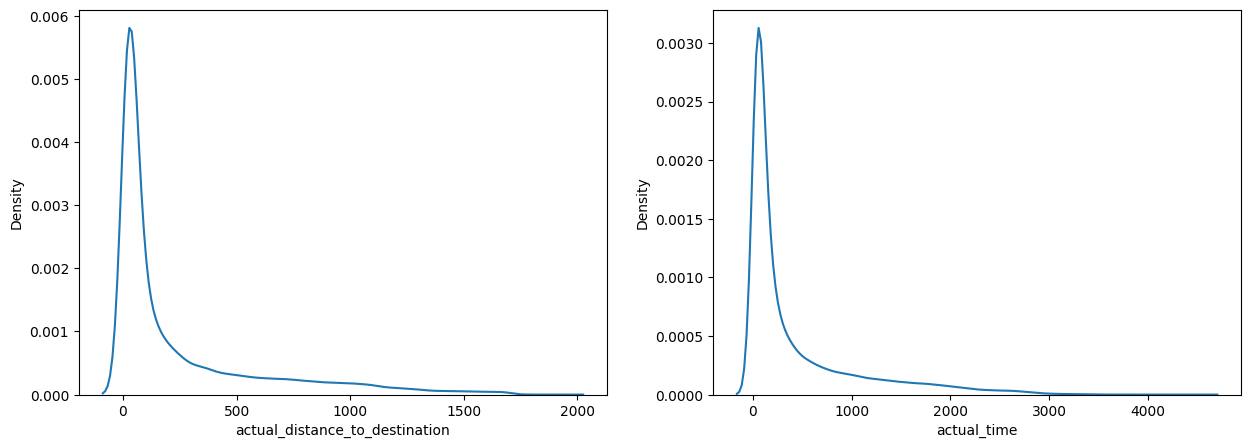

In [260]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data['actual_distance_to_destination'])

plt.subplot(1, 2, 2)
sns.kdeplot(data['actual_time'])

distributions are right-skewed, indicating most trips are short to medium duration, with a few very long trips.

In [261]:
agg_data = data.groupby(['trip_uuid']).agg(total_actual_distance = ('actual_distance_to_destination', 'sum'),
                                                                       total_actual_time = ('actual_time', 'sum'),
                                                                       total_osrm_dist=('osrm_distance', 'sum'),
                                                                       total_osrm_time=('osrm_time', 'sum'),
                                                                       total_segment_osrm_dist = ('segment_osrm_distance', 'sum'),
                                                                       total_od_time_diff=('od_time_diff', 'sum')).reset_index()

agg_data

,trip_uuid,total_actual_distance,total_actual_time,total_osrm_dist,total_osrm_time,total_segment_osrm_dist,total_od_time_diff
0,trip-153671041653548748,8860.812105,15682.0,10577.7647,7787.0,1320.4733,43680.492537
1,trip-153671042288605164,240.208306,399.0,269.4308,210.0,84.1894,913.174079
2,trip-153671043369099517,68163.502238,112225.0,89447.2488,65768.0,2545.2678,248694.383681
3,trip-153671052974046625,63.783978,182.0,78.0984,62.0,53.5761,971.585627
4,trip-153671055416136166,34.407865,92.0,38.1953,30.0,28.0647,251.365798
...,...,...,...,...,...,...,...
13544,trip-153861095625827784,141.057373,186.0,162.9473,148.0,64.8551,879.327869
13545,trip-153861104386292051,25.130640,33.0,26.5333,19.0,16.0883,121.181043
13546,trip-153861106442901555,93.743842,549.0,162.8499,134.0,104.8866,1266.359600
13547,trip-153861115439069069,355.281673,600.0,449.5383,446.0,223.5324,1320.402557


- H0: total osrm distance and total segment osrm distance on trip level are same
- H1: total osrm distance and total segment osrm distance on trip level are different

In [262]:
t, p = ttest_rel(agg_data['total_osrm_dist'], agg_data['total_segment_osrm_dist'])
t,p

(np.float64(30.022036879240254), np.float64(8.987138792375215e-192))

p < alpha (0.05),
- We reject the null hypothesis and conclude that on tripuuid level, total osrm distance is more than total segment osrm distance.
- Improvements needs to be done in segment/total distance calculation by osrm

In [263]:
def iqr_outlier_removal(dt, col):
  q1 = dt[col].quantile(0.25)
  q3 = dt[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return lower_bound, upper_bound

In [264]:
data['actual_speed'] = data['actual_distance_to_destination'] / (data['actual_time']/60)
data['osrm_speed'] = data['osrm_distance'] / (data['osrm_time']/60)

data['segment_actual_speed'] = data['segment_osrm_distance'] / (data['segment_actual_time']/60)

data['delay_ratio'] = data['actual_time'] / data['osrm_time']

Text(0.5, 0, 'Actual time without ourliers')

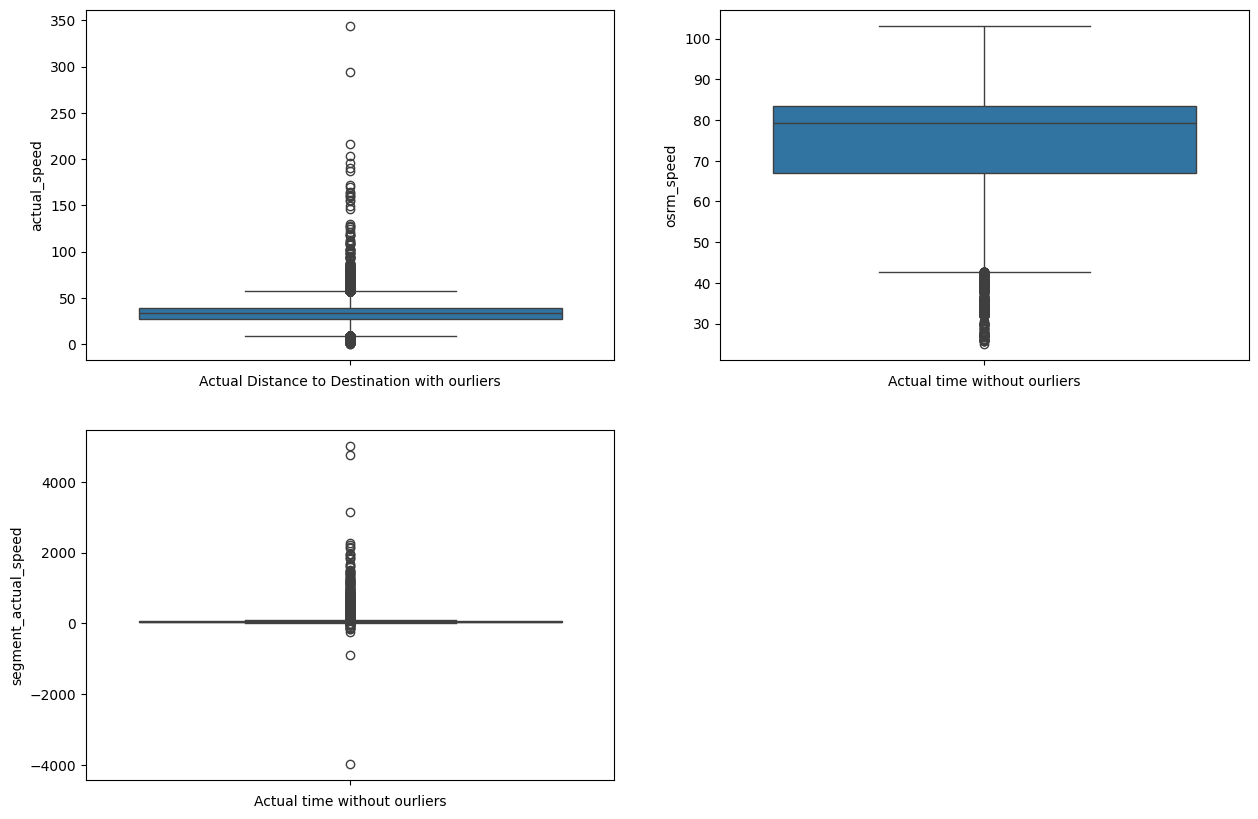

In [265]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data, y = 'actual_speed')
plt.xlabel('Actual Distance to Destination with ourliers')

plt.subplot(2, 2, 2)
sns.boxplot(data, y = 'osrm_speed')
plt.xlabel('Actual time without ourliers')

plt.subplot(2, 2, 3)
sns.boxplot(data, y = 'segment_actual_speed')
plt.xlabel('Actual time without ourliers')

In [266]:
def remove_outliers_multi(df, cols):
    mask = pd.Series(True, index=df.index)

    for col in cols:
        low, high = iqr_outlier_removal(df, col)
        mask &= df[col].between(low, high)

    return df[mask]

cols_to_filter = ['actual_speed', 'segment_actual_speed', 'delay_ratio']

data_filtered = remove_outliers_multi(data, cols_to_filter)

Text(0.5, 0, 'Actual time without ourliers')

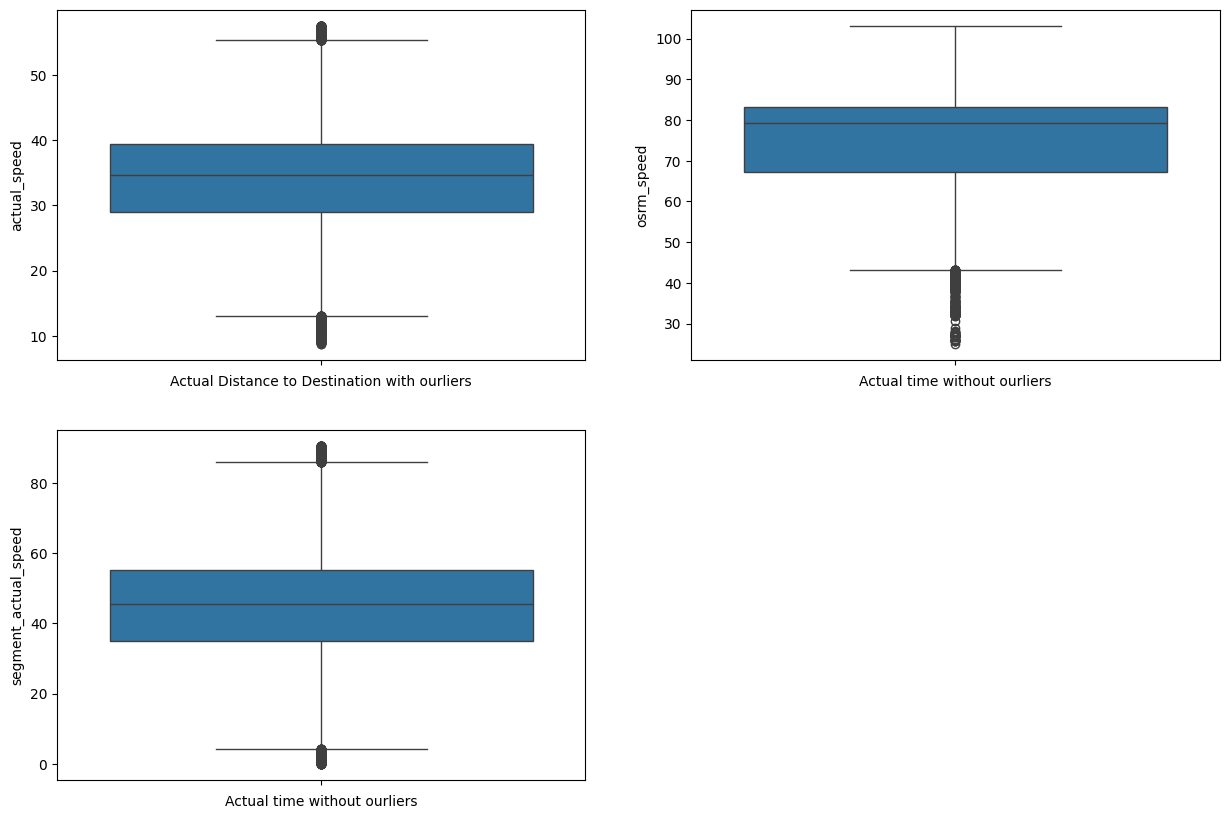

In [267]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data_filtered, y = 'actual_speed')
plt.xlabel('Actual Distance to Destination with ourliers')

plt.subplot(2, 2, 2)
sns.boxplot(data_filtered, y = 'osrm_speed')
plt.xlabel('Actual time without ourliers')

plt.subplot(2, 2, 3)
sns.boxplot(data_filtered, y = 'segment_actual_speed')
plt.xlabel('Actual time without ourliers')

In [268]:
data_filtered[['actual_distance_to_destination', 'osrm_distance']].corr()

,actual_distance_to_destination,osrm_distance
actual_distance_to_destination,1.000000,0.997241
osrm_distance,0.997241,1.000000


Actual distance and OSRM distance are highly correlated

In [269]:
data_filtered[['actual_time', 'osrm_time']].corr()

,actual_time,osrm_time
actual_time,1.000000,0.986889
osrm_time,0.986889,1.000000


Actual time and OSRM time are highly correlated

- null hypothesis: mean of actual time and osrm time is same
- alternate hypo.: mean of actual time and osrm time is not same

In [270]:
t, p = ttest_rel(data_filtered['actual_time'], data_filtered['osrm_time'])
t,p

(np.float64(240.27625421778265), np.float64(0.0))

highly positive t-statistic shows that actual time is more than osrm time. which is quite possible due to traffic, tyre puncture, engine breakdown

In [271]:
t, p = ttest_rel(data_filtered['actual_distance_to_destination'], data_filtered['osrm_distance'])
t,p

(np.float64(-227.21359340505043), np.float64(0.0))

Negative t-statistic shows that actual distance travelled is less than osrm distance, which might be possible due to driver's knowledge of shorcuts, local route or distance miss-calculation

A paired t-test shows a statistically significant difference between OSRM estimated and actual travel metrics (p < 0.001). Actual travel times are consistently higher than OSRM predictions, while traveled distances are slightly shorter. This indicates that delays arise from operational factors rather than route estimation errors, suggesting the modeling task should focus on delay correction instead of direct travel time prediction.

In [216]:
scaler = StandardScaler()
numeric_cols = ['actual_distance_to_destination','actual_time', 'osrm_distance', 'osrm_time', 'segment_actual_time', 'segment_osrm_distance']

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

Recommendation-
- Optimize Fleet for Intra-State Traffic: Since intra-state orders account for the highest volume of deliveries, introducing smaller trucks or tempos can help reduce wait times and operational costs. This will also allow the business to better capture the small vendor and individual consumer markets.

- Calibrate OSRM Estimates: The OSRM system requires improvement in both time and distance estimation. Currently, time estimates are often inflated while distance estimates are lower than actuals. Additionally, there are significant discrepancies between the sum of segment distances and the total trip distance that need addressing.

- Capture Delay Reasons: Data should be collected on specific reasons for delays to improve understanding of bottlenecks and refine future time estimates.

- Implement Crowdsourced Alerts: Drivers should be able to report roadblocks on a centralised portal to alert others traveling on similar routes, helping them avoid delays.

- Expand Last-Mile Connectivity: Strategic tie-ups and partnerships should be established to strengthen last-mile delivery networks.

- Incentivize New Customers: Discounts and bundle offers can be introduced to onboard new customers and increase market penetration.